In [307]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
os.chdir(r"C:\Users\kaborg15\Python_projects\Vibrent_Style_Quiz_Generation")

import pandas as pd
from resources.constants import *
from PIL import Image, ImageDraw

TEST_IMAGE_PATH = r"reports\figures\collage.jpg"
test_image = Image.open(TEST_IMAGE_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [308]:
THUMNAIL_SIZE = (512, 512)
test_image.thumbnail(THUMNAIL_SIZE)

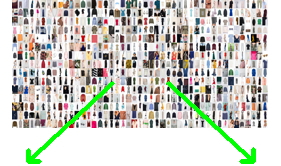

In [71]:
TREE_IMAGE_SIZE = (1024, 4096)
tree_image = Image.new("RGBA", TREE_IMAGE_SIZE, color="white")
tree_draw = ImageDraw.Draw(tree_image)

import cv2
import numpy as np
from PIL import Image

# PIL has no built-in arrow drawing function, so we use OpenCV to draw an arrow on a NumPy array
def draw_arrow_at_coordinates(im, start, end, color=(0,255,0), width=4):
    na = np.array(im)
    na = cv2.arrowedLine(na, start, end, color, width)
    return Image.fromarray(na)

#draw_arrow_at_coordinates(test_image, (10, 20), (test_image.width-40, test_image.height-60))
HEIGHT_EXPANSION = 1.3
WIDTH_EXPANSION = 1.1
ARROW_START_HEIGHT = 0.5
ARROW_END_WIDTH = 0.1
ARROW_END_HEIGHT_OFFSET = 5
ARROW_START_WIDTH = 0.1

def draw_split_arrows_on_image(im):
    expanded_image = Image.new("RGB", (int(im.width * WIDTH_EXPANSION), int(im.height * HEIGHT_EXPANSION)), color=(255,255,255))
    expanded_image.paste(im, ((expanded_image.width - im.width) // 2, 0))

    # Distance from the edge of the image to the end of the arrow
    arrow_end_width_offset = int(expanded_image.width * ARROW_END_WIDTH)
    # Distance from the center of the image to the start of the arrow
    arrow_start_width_offset = int(expanded_image.width * ARROW_START_WIDTH)
    expanded_image = draw_arrow_at_coordinates(expanded_image, 
                                               ((expanded_image.width // 2) + arrow_start_width_offset, int(expanded_image.height * ARROW_START_HEIGHT)), 
                                               (expanded_image.width - arrow_end_width_offset, expanded_image.height - ARROW_END_HEIGHT_OFFSET))
    expanded_image = draw_arrow_at_coordinates(expanded_image, 
                                               ((expanded_image.width // 2) - arrow_start_width_offset, int(expanded_image.height * ARROW_START_HEIGHT)), 
                                               (arrow_end_width_offset, expanded_image.height - ARROW_END_HEIGHT_OFFSET))
    return expanded_image

arrowed_test_image = draw_split_arrows_on_image(test_image)
arrowed_test_image

In [74]:
LEVEL_IMAGE_SCALE_DOWN = 0.8
PIXEL_OFFSET = 10

def draw_tree_level(tree_image, level_image, paste_widths, paste_height):
    new_paste_widths = []
    # Since we have a variable number of pastes, we need to keep track of whether the current paste is on the left or right
    is_left = True
    for current_paste_width in paste_widths:
        current_paste_width = current_paste_width - PIXEL_OFFSET if is_left else current_paste_width + PIXEL_OFFSET
        tree_image.paste(level_image, (current_paste_width, paste_height))
        new_paste_widths += [current_paste_width - (level_image.width // 2), current_paste_width + (level_image.width // 2)]
        
        is_left = not is_left

    paste_height += level_image.height
    return paste_height, new_paste_widths

paste_width = [(tree_image.width  - test_image.width) // 2]
paste_height = 0

level_image = arrowed_test_image.copy()

for i in range(3):
    paste_height, paste_width = draw_tree_level(tree_image, level_image, paste_width, paste_height)
    #level_image = level_image.resize((int(level_image.width * LEVEL_IMAGE_SCALE_DOWN), int(level_image.height * LEVEL_IMAGE_SCALE_DOWN)))

In [81]:
TREE_IMAGE_SIZE = (1024, 4096)
tree_image = Image.new("RGBA", TREE_IMAGE_SIZE, color="white")

level_image = arrowed_test_image.copy()

num_images_to_paste = 1
paste_width = (tree_image.width  - test_image.width) // 2
paste_height = 0

tree_image.paste(level_image, (paste_width, paste_height))
remaining_paste_width = tree_image.width - test_image.width

paste_height += level_image.height
num_images_to_paste *= 2
remaining_paste_width //= 2

workable_width = remaining_paste_width + test_image.width
level_images_width = workable_width // num_images_to_paste

level_image.thumbnail((level_images_width, level_image.height))

current_paste_width = (tree_image.width - workable_width) // 2
for i in range(num_images_to_paste):
    tree_image.paste(level_image, (current_paste_width, paste_height))
    current_paste_width += level_images_width


In [149]:

import cv2
import numpy as np
from PIL import Image

# PIL has no built-in arrow drawing function, so we use OpenCV to draw an arrow on a NumPy array
def draw_arrow_at_coordinates(im, start, end, color=(0,255,0), width=2):
    na = np.array(im)
    na = cv2.arrowedLine(na, start, end, color, width)
    return Image.fromarray(na)

#draw_arrow_at_coordinates(test_image, (10, 20), (test_image.width-40, test_image.height-60))
HEIGHT_EXPANSION = 1.3
WIDTH_EXPANSION = 1.1

def draw_level_image(im):
    expanded_image = Image.new("RGB", (int(im.width * WIDTH_EXPANSION), int(im.height * HEIGHT_EXPANSION)), color=(255,255,255))
    expanded_image.paste(im, ((expanded_image.width - im.width) // 2, 0))
    return expanded_image

def draw_tree_level(tree_image, level_image, paste_height, num_images_to_paste, margin, parent_positions, arrow_coordinates):
    level_width = tree_image.width - margin
    level_image_width = level_width // num_images_to_paste
    level_image_copy = level_image.copy()
    level_image_copy.thumbnail((level_image_width, level_image.height))
    
    current_paste_width = margin // 2
    new_parent_positions = []
    for i in range(num_images_to_paste):
        tree_image.paste(level_image_copy, (current_paste_width, paste_height))

        # Keep track of the center of the current image for pasting arrows on later
        current_center = (current_paste_width + (level_image_copy.width // 2), paste_height + (level_image_copy.height // 2))
        new_parent_positions.append(current_center)

        # Draw arrows from the current image to its parent, unless it's the first level
        if num_images_to_paste > 1:
            # The parent of the current image is at index i // 2 in the parent_positions list
            parent_center = parent_positions[i // 2]
            arrow_coordinates.append((parent_center, current_center, level_image_copy.width, level_image_copy.height))

        current_paste_width += level_image_width
    
    paste_height += level_image_copy.height
    num_images_to_paste *= 2
    margin //= 2

    return paste_height, num_images_to_paste, margin, new_parent_positions

TREE_IMAGE_SIZE = (1024, 4096)
tree_image = Image.new("RGBA", TREE_IMAGE_SIZE, color="white")
level_image = draw_level_image(test_image)

num_images_to_paste = 1
paste_height = 0
margin = tree_image.width - level_image.width

parent_positions = []
arrow_coordinates = []

for i in range(6):
    paste_height, num_images_to_paste, margin, parent_positions = draw_tree_level(
        tree_image, level_image, paste_height, num_images_to_paste, margin, parent_positions, arrow_coordinates
        )

ARROW_START_HEIGHT_OFFSET = 0.2
ARROW_START_WIDTH_OFFSET = 0.01

ARROW_END_HEIGHT_OFFSET = 0.4
ARROW_END_WIDTH_OFFSET = 0.1


for arrow_start, arrow_end, target_width, target_height in arrow_coordinates:
    is_left = 1 if arrow_start[0] < arrow_end[0] else -1

    arrow_start = (arrow_start[0] + int(arrow_start[0] * ARROW_START_WIDTH_OFFSET) * is_left, arrow_start[1] + int(target_height * ARROW_START_HEIGHT_OFFSET))
    arrow_end = (arrow_end[0], arrow_end[1] - int(target_height * ARROW_END_HEIGHT_OFFSET))
    tree_image = draw_arrow_at_coordinates(tree_image, arrow_start, arrow_end)

In [151]:
import pandas as pd
from resources.constants import *

OUTFIT_EMBEDDINGS_DF_PATH = r"resources\data\outfit_embeddings_df.pkl"
REPRESENTATION_COLUMN = "outfit_embeddings"

pictures_df = pd.read_csv(PICTURE_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)
user_triplets_df = pd.read_csv(USER_ACTIVITY_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)

embeddings_df = pd.read_pickle(OUTFIT_EMBEDDINGS_DF_PATH)

In [181]:
import time
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import random
from IPython.display import clear_output

from src.display_images import display_image_ids


OUTFIT_EMBEDDINGS_DF_PATH = r"resources\data\outfit_embeddings_df.pkl"
REPRESENTATION_COLUMN = "outfit_embeddings"
NUM_SAMPLES_PER_CLUSTER = 27

# Note: not implemented for more than 2 clusters yet
NUM_CLUSTERS = 2

def cluster_current_split(current_cluster_df, collect_cluster_samples=True):
    outfit_representations = np.stack(current_cluster_df[REPRESENTATION_COLUMN].values)
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0, n_init="auto").fit(outfit_representations)
    current_cluster_df["cluster"] = kmeans.labels_

    cluster_samples = []
    for i in range(NUM_CLUSTERS):
        cluster_outfits = current_cluster_df[current_cluster_df["cluster"] == i].copy()
        cluster_embeddings = np.stack(cluster_outfits[REPRESENTATION_COLUMN].values)
        
        # Properly represent the diversity of the cluster by applying KMeans to the embeddings
        if collect_cluster_samples:
            num_cluster_samples = min(NUM_SAMPLES_PER_CLUSTER, len(cluster_outfits))
            cluster_kmeans = KMeans(n_clusters=num_cluster_samples, random_state=1, n_init="auto").fit(cluster_embeddings)
            cluster_outfits["representation_cluster"] = cluster_kmeans.labels_
            cluster_representation = cluster_outfits.groupby("representation_cluster").first().reset_index()
            cluster_samples.append(cluster_representation)
        
    return current_cluster_df, cluster_samples

#Run through the quiz to get the image samples from each split
CONVERGE_THRESHOLD = 30

outfits_to_lead_picture_id_dict = embeddings_df.set_index("id")["lead_picture_id"].to_dict()
recursive_cluster_list = [(embeddings_df.dropna().copy(), 1)]

run_num = 0
level_cluster_samples = []
while len(recursive_cluster_list) > 0:
    recursive_cluster_df, parent_level_depth = recursive_cluster_list.pop(0)
    current_cluster_df, cluster_samples = cluster_current_split(recursive_cluster_df, collect_cluster_samples=True)
    
    current_level_depth = parent_level_depth + 1
    for sample in cluster_samples:
        level_cluster_samples.append((sample, len(current_cluster_df), current_level_depth, run_num, cluster_num))
        
    clear_output(wait=True)
    for cluster_num in range(NUM_CLUSTERS):
        cluster_i_df = current_cluster_df[current_cluster_df["cluster"] == cluster_num].copy()
        cluster_i_df = cluster_i_df.drop(columns=["cluster"])

        if len(cluster_i_df) < CONVERGE_THRESHOLD:
            print(f"Cluster {run_num}.{cluster_num} has converged at level {current_level_depth} with {len(cluster_i_df)} outfits")
            continue

        #print(f"Cluster {run_num}.{cluster_num} has {len(cluster_i_df)} outfits")
        recursive_cluster_list.append((cluster_i_df, current_level_depth))

    print(f"Run {run_num} completed, {len(recursive_cluster_list)} clusters left")
    run_num += 1


# create a dataframe for some statistics
to_dataframe_list = []
for cluster_df, num_outfits, level, run_num, cluster_num in level_cluster_samples:
    to_dataframe_list.append([run_num, cluster_num, level, num_outfits])
cluster_samples_df = pd.DataFrame(to_dataframe_list, columns=["run_num", "cluster_num", "level", "num_outfits"])

Cluster 467.0 has converged at level 14 with 14 outfits
Cluster 467.1 has converged at level 14 with 17 outfits
Run 467 completed, 0 clusters left


In [310]:
from IPython.display import display
from tqdm.notebook import tqdm

# Convert the images of each cluster into a collage, and sort them by depth
outfits_to_lead_picture_id_dict = embeddings_df.set_index("id")["lead_picture_id"].to_dict()
def construct_cluster_collage(cluster_samples_df):
    image_ids = [outfits_to_lead_picture_id_dict[outfit_id] for outfit_id in cluster_samples_df["id"].values]
    cluster_collage = display_image_ids(image_ids)
    return cluster_collage

level_image_dict = {1: [test_image]}

for i, cluster_data in tqdm(enumerate(level_cluster_samples)):
    samples, num_outfits, level, run_num, cluster_num = cluster_data
    if level > 8:
        break
    if level not in level_image_dict:
        level_image_dict[level] = []
    
    cluster_collage = construct_cluster_collage(samples)
    level_image_dict[level].append(cluster_collage)
    

0it [00:00, ?it/s]

Error opening image at resources\data\dataset\images\picture.df94ca2ef38e4f8fa2a830d883a54fbb
Error opening image at resources\data\dataset\images\picture.df94ca2ef38e4f8fa2a830d883a54fbb
Error opening image at resources\data\dataset\images\picture.df94ca2ef38e4f8fa2a830d883a54fbb
Error opening image at resources\data\dataset\images\picture.df94ca2ef38e4f8fa2a830d883a54fbb
Error opening image at resources\data\dataset\images\picture.df94ca2ef38e4f8fa2a830d883a54fbb
Error opening image at resources\data\dataset\images\picture.df94ca2ef38e4f8fa2a830d883a54fbb


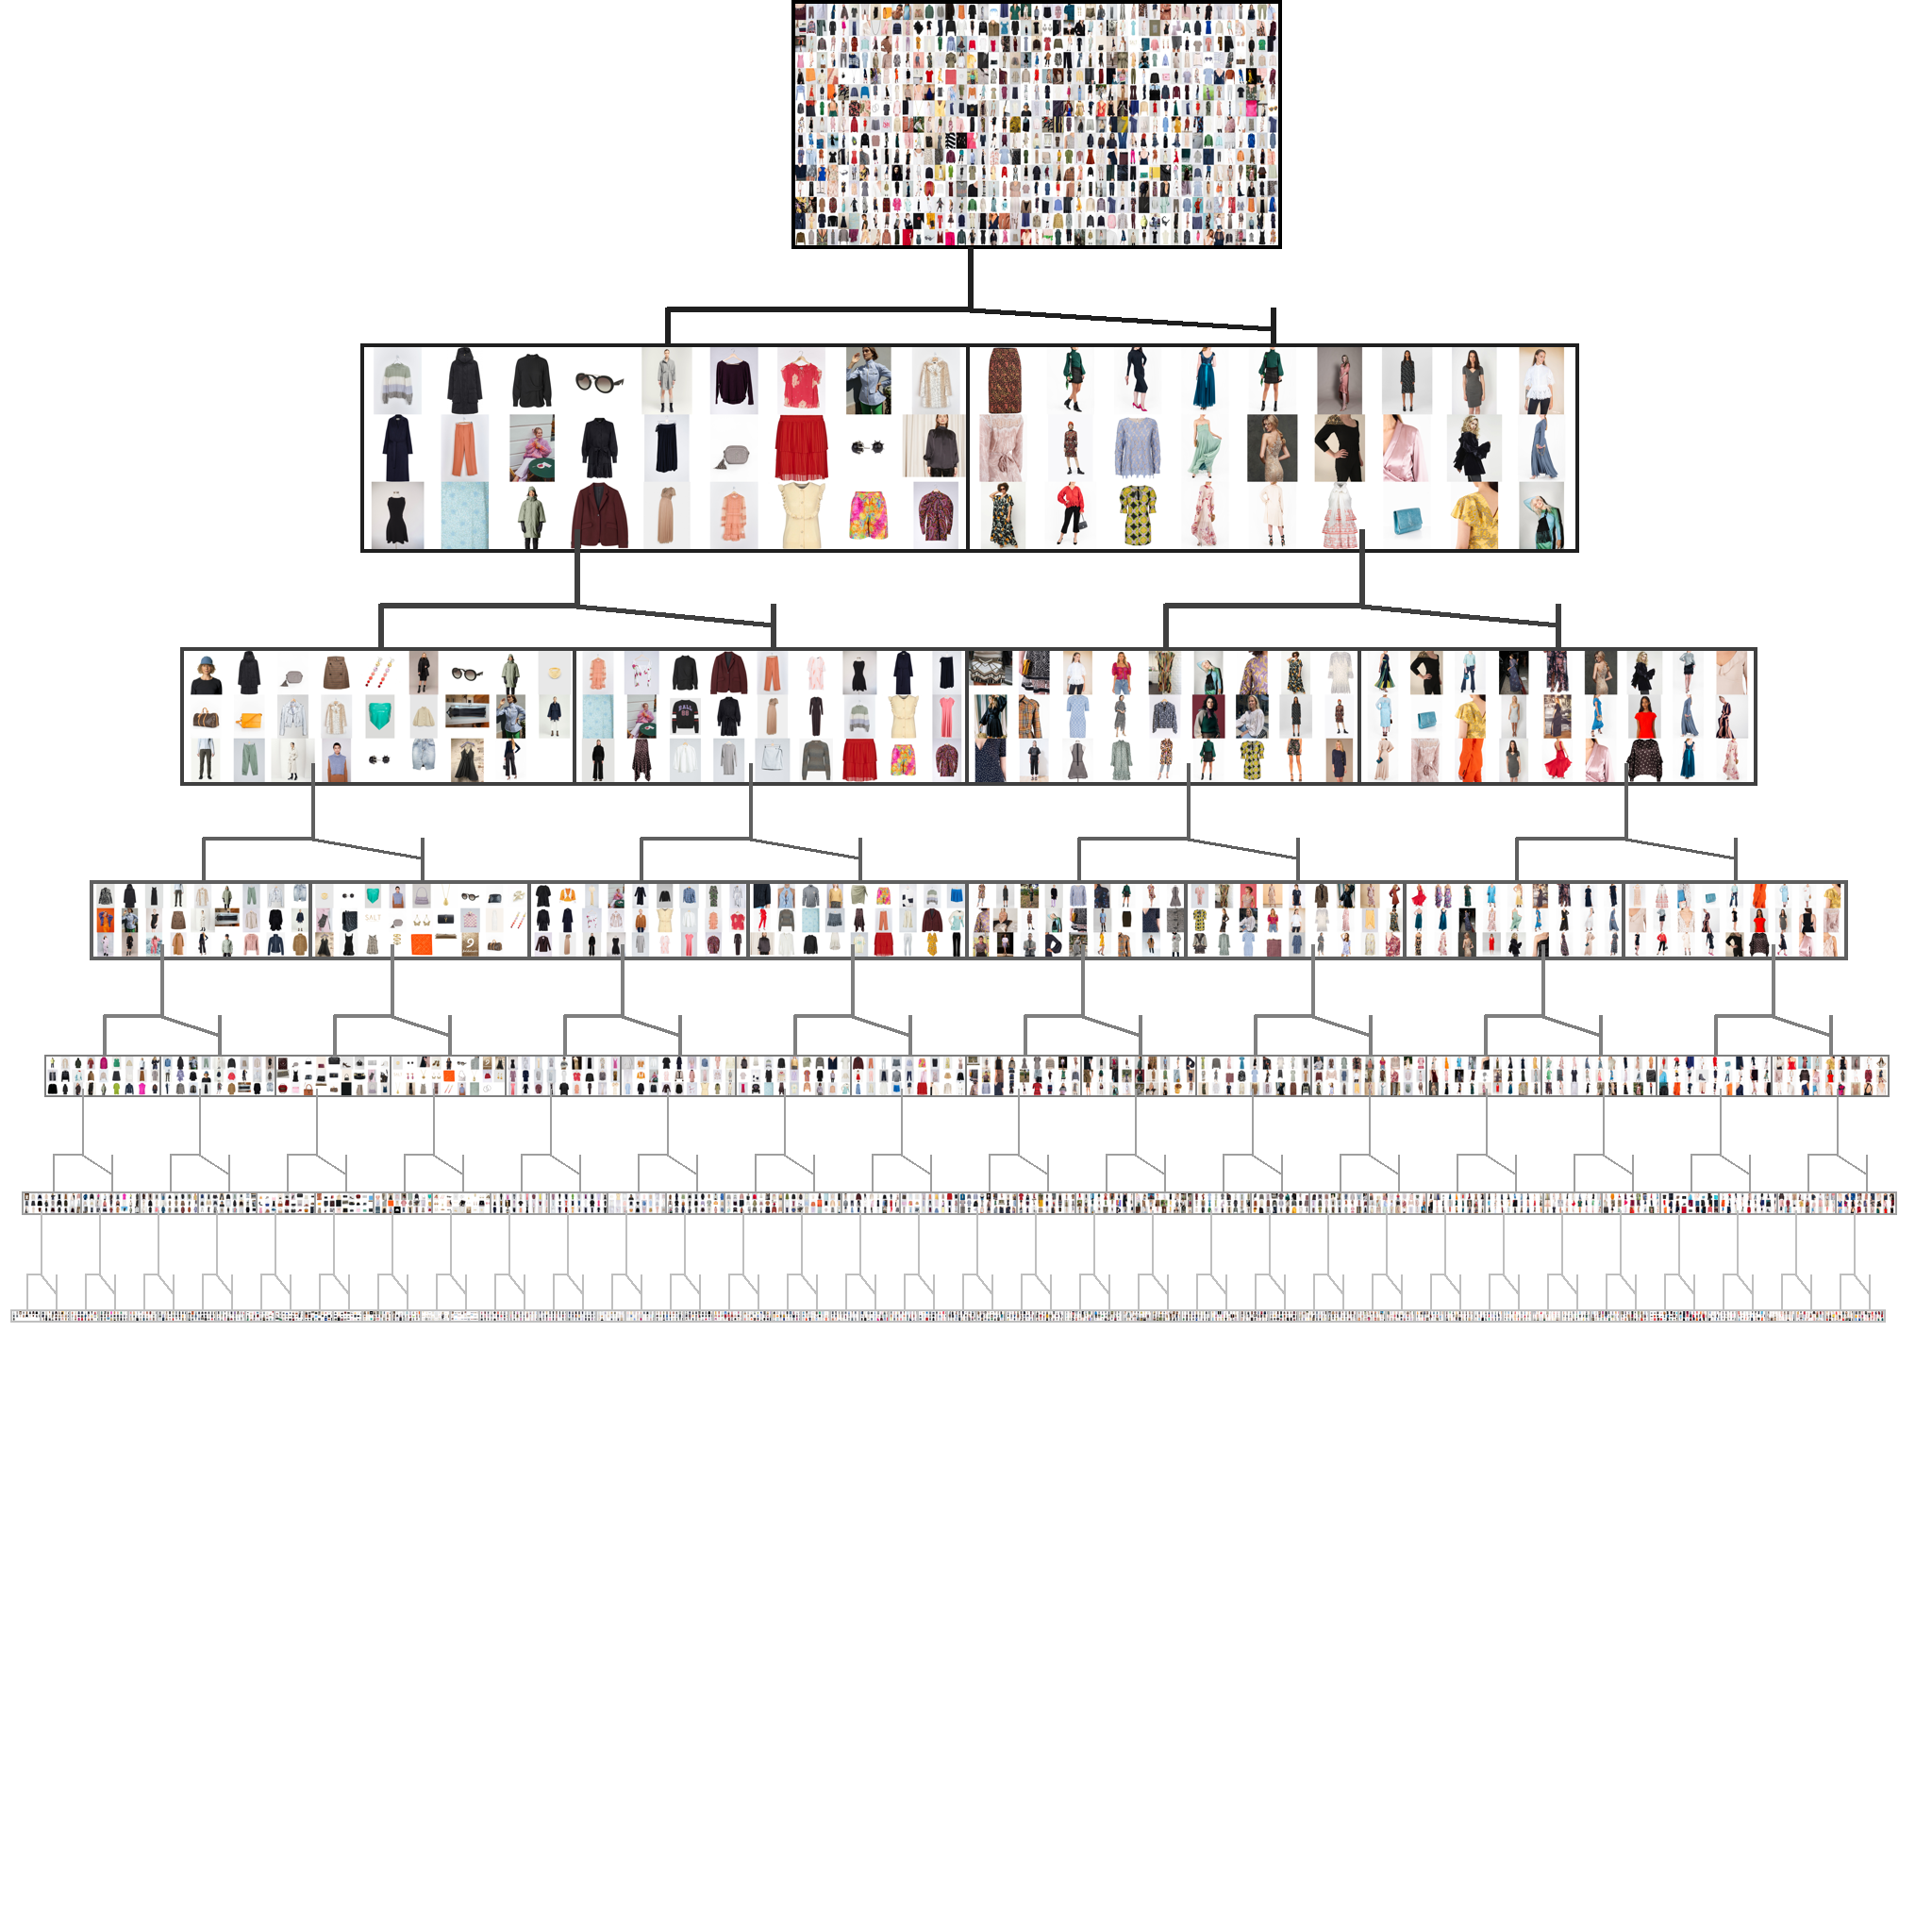

In [362]:
import math
import cv2
import numpy as np
from PIL import Image

# PIL has no built-in arrow drawing function, so we use OpenCV to draw an arrow on a NumPy array
# def draw_arrow_at_coordinates(im, start, end, color=(0,255,0), width=2):
#     na = np.array(im)
#     na = cv2.arrowedLine(na, start, end, color, width)
#     return Image.fromarray(na)

def draw_curved_arrow_pil(im, start, end, color=(0,255,0), width=2, tip_length=20):
    draw = ImageDraw.Draw(im)
    
    # Calculate control point for bezier curve
    # control_point = (
    #     (start[0] + end[0]) // 2,
    #     start[1] - abs(end[0] - start[0]) // 4
    # )
    control_point = start
    # Draw the curved line
    draw.line([start, end], fill=color, width=width, joint="curve")
    
    # Calculate the direction of the tip
    tip_direction = (end[0] - control_point[0], end[1] - control_point[1])
    length = (tip_direction[0]**2 + tip_direction[1]**2)**0.5
    tip_direction = (tip_direction[0]/length, tip_direction[1]/length)
    
    # Calculate the two points that make up the arrowhead
    arrow_tip1 = (
        int(end[0] - tip_length * tip_direction[0] + tip_length/2 * -tip_direction[1]),
        int(end[1] - tip_length * tip_direction[1] + tip_length/2 * tip_direction[0])
    )
    arrow_tip2 = (
        int(end[0] - tip_length * tip_direction[0] - tip_length/2 * -tip_direction[1]),
        int(end[1] - tip_length * tip_direction[1] - tip_length/2 * tip_direction[0])
    )
    
    # Draw the arrowhead
    draw.line([end, arrow_tip1], fill=color, width=width)
    draw.line([end, arrow_tip2], fill=color, width=width)
    
    return im

HEIGHT_EXPANSION = 1
WIDTH_EXPANSION = 1

def draw_level_image(im, frame_size=8, frame_color=(0,0,0)):
    frame_image = Image.new("RGB", (im.width + frame_size, im.height + frame_size), color=frame_color)
    frame_image.paste(im, (frame_size // 2, frame_size // 2))
    expanded_image = Image.new("RGB", (int(frame_image.width * WIDTH_EXPANSION), int(frame_image.height * HEIGHT_EXPANSION)), color=BACKGROUND_COLOR)
    expanded_image.paste(frame_image, ((expanded_image.width - frame_image.width) // 2, 0))
    return expanded_image



def draw_tree_level(tree_image, level_images, paste_height, num_images_to_paste, margin, parent_positions, arrow_coordinates):
    level_width = tree_image.width - margin
    level_image_width = level_width // num_images_to_paste
    
    current_paste_width = margin // 2
    new_parent_positions = []
    for i in range(num_images_to_paste):
        level_image_copy = level_images[i].copy()
        level_image_copy.thumbnail((level_image_width, level_image_copy.height))

        # Calculate the current level of the image, a bit crude but it works and we don't track this otherwise
        current_level = math.log2(num_images_to_paste)
        
        border_width = FRAME_SIZE(current_level)
        bracket_color = get_gradient_color(START_COLOR, END_COLOR, current_level / NUM_LEVELS)

        level_image_copy = draw_level_image(level_image_copy, frame_size=border_width, frame_color=bracket_color)

        if num_images_to_paste == 1:
            current_paste_width += FIRST_IMAGE_OFFSET

        tree_image.paste(level_image_copy, (current_paste_width, paste_height))

        # Keep track of the center of the current image for pasting arrows on later
        current_center = (current_paste_width + (level_image_copy.width // 2), paste_height + (level_image_copy.height // 2))
        new_parent_positions.append(current_center)

        # Draw arrows from the current image to its parent, unless it's the first level
        if num_images_to_paste > 1:
            # The parent of the current image is at index i // 2 in the parent_positions list
            parent_center = parent_positions[i // 2]
            arrow_coordinates.append((parent_center, current_center, level_image_copy.width, level_image_copy.height, current_level))

        current_paste_width += level_image_width
    
    paste_height += level_image_copy.height + VERTICAL_PADDING
    num_images_to_paste *= 2
    margin //= 2

    return paste_height, num_images_to_paste, margin, new_parent_positions

def get_gradient_color(start_color, end_color, ratio):
    return tuple(int(start_color[i] + (end_color[i] - start_color[i]) * ratio) for i in range(3))

TREE_IMAGE_SIZE = (2048, 2048)
BACKGROUND_COLOR = (255, 255, 255)
FRAME_COLOR = (0, 0, 0)
FRAME_SIZE = lambda x: 8 if x <= 3 else 4

VERTICAL_PADDING = 100
HORIZONTAL_PADDING = 20
FIRST_IMAGE_OFFSET = 75

tree_image = Image.new("RGBA", TREE_IMAGE_SIZE, color=BACKGROUND_COLOR)
level_image = draw_level_image(level_image_dict[1][0], frame_size=FRAME_SIZE(1))

num_images_to_paste = 1
paste_height = 0
margin = tree_image.width - level_image.width

parent_positions = []
arrow_coordinates = []


NUM_LEVELS = 8
for i in range(1, NUM_LEVELS):
    level_images = level_image_dict[i]
    paste_height, num_images_to_paste, margin, parent_positions = draw_tree_level(
        tree_image, level_images, paste_height, num_images_to_paste, margin, parent_positions, arrow_coordinates
        )

ARROW_START_HEIGHT_OFFSET = lambda x: 0.4 if x == 1 else 0.54
ARROW_START_WIDTH_OFFSET = 0.01

ARROW_END_HEIGHT_OFFSET = 0.4
ARROW_END_WIDTH_OFFSET = 0.1

# START_COLOR = (0, 100, 0)
# END_COLOR = (0, 255, 0)
START_COLOR = (0, 0, 0)
END_COLOR = (255, 255, 255)

MAX_ARROW_LENGTH = 100


BRACKET_START_HEIGHT_OFFSET = 0.59
BRACKET_END_HEIGHT_OFFSET = 0.5
SPLIT_POINT = 0.65
RIGHT_HEIGHT_OFFSET = 20

def draw_bracket_lines(im, start, end, color=(0,255,0), width=2):
    draw = ImageDraw.Draw(im)
    draw.line([start, end], fill=color, width=width)

    return im

# Translate our arrow coordinates into a dictoinary so that we can take the other child into account when drawing the arrows
arrow_coordinates_dict = {}
for arrow_start, arrow_end, target_width, target_height, current_level in arrow_coordinates:
    if arrow_start not in arrow_coordinates_dict:
        arrow_coordinates_dict[arrow_start] = []
    arrow_coordinates_dict[arrow_start].append((arrow_end, target_width, target_height, current_level))

for parent_start, children in arrow_coordinates_dict.items():
    first_child_width = children[0][0][0]
    second_child_width = children[1][0][0]
    midpoint = (first_child_width + second_child_width) // 2
    
    for arrow_end, target_width, target_height, current_level in children:
        is_right = 1 if parent_start[0] < arrow_end[0] else 0

        bracket_color = get_gradient_color(START_COLOR, END_COLOR, current_level / NUM_LEVELS)
        bracket_width = 6 if current_level < 3 else 4 if current_level < 5 else 2

        parent_height_start = parent_start[1] + int(target_height * BRACKET_START_HEIGHT_OFFSET)
        target_height_end = arrow_end[1] - int(target_height * BRACKET_END_HEIGHT_OFFSET)

        bracket_split_height = int((target_height_end - parent_height_start) * SPLIT_POINT) + parent_height_start

        bracket_start = (midpoint, parent_height_start)
        bracket_split_point = (midpoint, bracket_split_height)

        tree_image = draw_bracket_lines(tree_image, bracket_start, bracket_split_point, color=bracket_color, width=bracket_width)

        bracket_split_point = (bracket_split_point[0], bracket_split_height + RIGHT_HEIGHT_OFFSET * is_right)
        bracket_hover_end = (arrow_end[0], bracket_split_height + RIGHT_HEIGHT_OFFSET * is_right)
        tree_image = draw_bracket_lines(tree_image, bracket_split_point, bracket_hover_end, color=bracket_color, width=bracket_width)

        bracket_hover_end = (arrow_end[0], bracket_split_height - bracket_width // 3)
        bracket_end_point = (arrow_end[0], target_height_end)
        tree_image = draw_bracket_lines(tree_image, bracket_hover_end, bracket_end_point, color=bracket_color, width=bracket_width)

tree_image

In [ ]:
for parent_start, children in arrow_coordinates_dict.items():
    first_child_width = children[0][0][0]
    second_child_width = children[1][0][0]
    midpoint = (first_child_width + second_child_width) // 2
    
    for arrow_end, target_width, target_height, current_level in children:
        midpoint_offset = 25 if current_level < 2 else 16 if current_level < 3 else 6 if current_level < 5 else 0
        is_left = 1 if parent_start[0] < parent_start[0] else -1

        arrow_start_heigh_offset = ARROW_START_HEIGHT_OFFSET(current_level)
        arrow_start = (midpoint - midpoint_offset, parent_start[1] + int(target_height * arrow_start_heigh_offset))
        arrow_end = (arrow_end[0], arrow_end[1] - int(target_height * ARROW_END_HEIGHT_OFFSET))

        # arrow_length = ((arrow_end[0] - arrow_start[0])**2 + (arrow_end[1] - arrow_start[1])**2)**0.5
        # if arrow_length > MAX_ARROW_LENGTH:
        #     arrow_end = (arrow_start[0] + int((arrow_end[0] - arrow_start[0]) * MAX_ARROW_LENGTH / arrow_length), arrow_start[1] + int((arrow_end[1] - arrow_start[1]) * MAX_ARROW_LENGTH / arrow_length))

        arrow_width = 6 if current_level < 3 else 4 if current_level < 5 else 2
        arrow_tip_length = 15 if current_level < 3 else 8 if current_level < 5 else 4
        arrow_color = get_gradient_color(START_COLOR, END_COLOR, current_level / 7)
        tree_image = draw_curved_arrow_pil(tree_image, arrow_start, arrow_end, width=arrow_width, tip_length=arrow_tip_length, color=arrow_color)
tree_image

In [291]:
tree_image.save(r"reports\figures\style_quiz_tree.png")

In [264]:
arrow_coordinates_dict

{(512, 76): [((393, 220), 440, 135, 1.0), ((732, 220), 440, 135, 1.0)],
 (393, 220): [((223, 330), 275, 85, 2.0), ((435, 330), 275, 85, 2.0)],
 (732, 220): [((647, 330), 275, 85, 2.0), ((859, 330), 275, 85, 2.0)],
 (223, 330): [((119, 396), 152, 46, 3.0), ((236, 396), 152, 46, 3.0)],
 (435, 330): [((353, 396), 152, 46, 3.0), ((470, 396), 152, 46, 3.0)],
 (647, 330): [((587, 396), 152, 46, 3.0), ((704, 396), 152, 46, 3.0)],
 (859, 330): [((821, 396), 152, 46, 3.0), ((938, 396), 152, 46, 3.0)],
 (119, 396): [((60, 431), 79, 24, 4.0), ((121, 431), 79, 24, 4.0)],
 (236, 396): [((182, 431), 79, 24, 4.0), ((243, 431), 79, 24, 4.0)],
 (353, 396): [((304, 431), 79, 24, 4.0), ((365, 431), 79, 24, 4.0)],
 (470, 396): [((426, 431), 79, 24, 4.0), ((487, 431), 79, 24, 4.0)],
 (587, 396): [((548, 431), 79, 24, 4.0), ((609, 431), 79, 24, 4.0)],
 (704, 396): [((670, 431), 79, 24, 4.0), ((731, 431), 79, 24, 4.0)],
 (821, 396): [((792, 431), 79, 24, 4.0), ((853, 431), 79, 24, 4.0)],
 (938, 396): [((914,

In [ ]:
for arrow_start, arrow_end, target_width, target_height, current_level in arrow_coordinates:
    is_left = 1 if arrow_start[0] < arrow_end[0] else -1

    arrow_start = (arrow_start[0] + int(arrow_start[0] * ARROW_START_WIDTH_OFFSET) * is_left, arrow_start[1] + int(target_height * ARROW_START_HEIGHT_OFFSET))
    arrow_end = (arrow_end[0], arrow_end[1] - int(target_height * ARROW_END_HEIGHT_OFFSET))

    # arrow_length = ((arrow_end[0] - arrow_start[0])**2 + (arrow_end[1] - arrow_start[1])**2)**0.5
    # if arrow_length > MAX_ARROW_LENGTH:
    #     arrow_end = (arrow_start[0] + int((arrow_end[0] - arrow_start[0]) * MAX_ARROW_LENGTH / arrow_length), arrow_start[1] + int((arrow_end[1] - arrow_start[1]) * MAX_ARROW_LENGTH / arrow_length))



    arrow_width = 6 if current_level < 3 else 4 if current_level < 5 else 2
    arrow_tip_length = 15 if current_level < 3 else 8 if current_level < 5 else 4
    arrow_color = get_gradient_color(START_COLOR, END_COLOR, current_level / 7)
    tree_image = draw_curved_arrow_pil(tree_image, arrow_start, arrow_end, width=arrow_width, tip_length=arrow_tip_length, color=arrow_color)
tree_image